[1.50127985 0.2968122  0.77271257 0.3868908  0.47856716 0.70557563
 0.79129098 0.46002319 0.43230584 0.76018642 0.48933824 0.6167994
 0.83579434 0.87229139 0.99215516 0.9759304  0.19284538 0.36738856
 0.51720058 0.09383888]
1.0
[1.        0.0355142 1.       ]


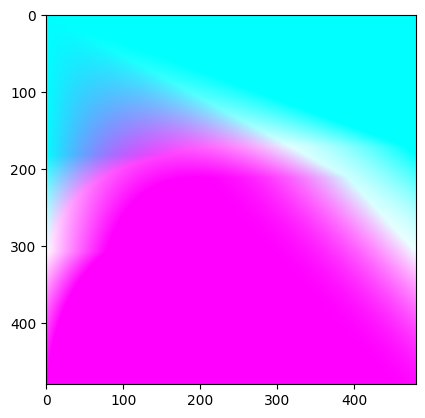

In [10]:
import grn
import numpy as np
import matplotlib.pyplot as plt
from genome import *



nin = 2
nout = 3
nreg = 1

genome = random_genome(nin, nout, nreg)
print(genome)

gsquare = grn.GRN(genome)
gsquare.random(nin=nin, nout=nout, nreg=nreg)

N = 480


matrix = np.zeros((N,N,3))
gsquare.step(25)
for i in range(N):
    for j in range(N):
        gsquare.set_input([i/N, j/N])
        gsquare.step()   
        out = gsquare.get_output()
        # if max(out) > 1:
        #     print("wtf")
        # print(out)
        matrix[i][j] = out


print(np.max(matrix))
plt.imshow(matrix)

print(out)
# plt.savefig("test.png")

[0.83074085 0.27022698 0.26756507 0.03248806 0.88587228 0.30519449
 0.45431266 0.09048048 0.64653699 0.01946854 0.00431894 0.78963347
 0.13627122 0.39420332 0.40361865 0.13011066 0.06003118 0.88615544
 0.05100996 0.50485632]


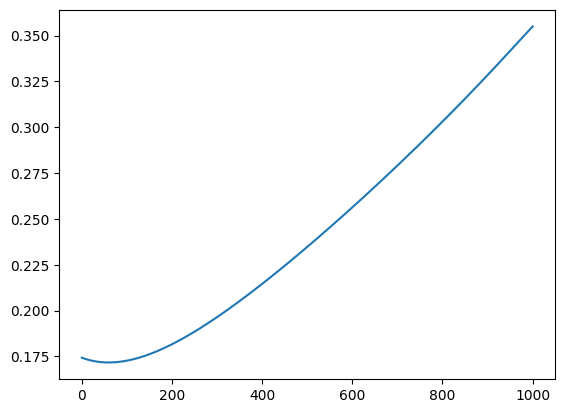

In [18]:
from grn import GRN
import matplotlib.pyplot as plt



nin = 2
nout = 3
nreg = 1

genome = random_genome(nin, nout, nreg)
gsquare = grn.GRN(genome)

print(gsquare.genome)
gsquare.reset()

gsquare.step(nsteps=25)

outputs = []
outputs.append(gsquare.get_output())


for i in range(1000):
    # g.set_input([0.5, 0.5])
    gsquare.set_input([0.1])
    gsquare.step()
    outputs.append(gsquare.get_output())
    # print(g.concentrations)

plt.plot(outputs)

In [19]:
print("grn concentrations summ should be  1 : ", np.sum(gsquare.concentrations[nin:]))
print("grn concentrations ", gsquare.concentrations)
print("grn genome ", gsquare.genome)
print("len genome ",len(gsquare.genome))


grn concentrations summ should be  1 :  0.3173528163650262
grn concentrations  [0.1        0.35492433 0.         0.         0.11816268 0.19919014]
grn genome  [0.83074085 0.27022698 0.26756507 0.03248806 0.88587228 0.30519449
 0.45431266 0.09048048 0.64653699 0.01946854 0.00431894 0.78963347
 0.13627122 0.39420332 0.40361865 0.13011066 0.06003118 0.88615544
 0.05100996 0.50485632]
len genome  20


In [ ]:
import matplotlib.pyplot as plt 

tg = GRN()
gsquare.reset()

tg.from_genome(gsquare.genome)
tg.from_genome_cmaes(es.best.x)
# tg.random(nin=n_in, nout=n_out, nreg=10)
print(es.best.x)

yg = problem.run_grn(gsquare)
ytg = problem.run_grn(tg)
# ytg = problem.run_grn(r)
# problem.run_grn(g)
plt.plot(xtrain, yg, label="grn")
plt.plot(xtrain, ytg, label="tg")
plt.plot(xtrain, ytrain, label = "target")

err = np.linalg.norm(ytrain - np.array(ytg))
print("err", err)
plt.legend()
# g.from_genome_cmaes(cma_result[0])
# print(tg)
# print("best grn fit: ", problem.run_grn(tg.genome))

# DEAP test 

In [ ]:
import random
from deap import base, creator, tools, algorithms




# 1. Define the fitness and individual types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

# 2. Set up the toolbox (genetic operators)
toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)  # Gene: random float in [0, 1]
toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_float,
    n=5  # Genome length = 5
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    return sum(individual),

# 3. Define genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Crossover (blend parents)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=0.5, low=0.0, up = 1.0, indpb=0.1)  # Mutation
toolbox.register("select", tools.selTournament, tournsize=3)  # Selection
toolbox.register("evaluate", evaluate)  # Fitness = sum of genome values

# 4. Create population and run the GA
population = toolbox.population(n=50)  # 50 individuals
algorithms.eaSimple(
    population,
    toolbox,
    cxpb=0.0,       # Crossover probability
    mutpb=0.2,      # Mutation probability
    ngen=100,        # Generations
    verbose=True    # Print progress
)

# 5. Print the best solution
best_individual = tools.selBest(population, k=)[0]
print(f"\nBest genome: {best_individual}")
print(f"Best fitness (sum): {best_individual.fitness.values[0]}")

In [1]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
from grn import GRN
import problem as p 
import matplotlib.pyplot as plt
from evolver import grneat
from genome import random_genome
from mutation import *
from crossover import *
# grn hyperparameters 
nin = 2
nout = 3
nreg = 50

a = 0
f = 0

size = nin + nout + nreg
genome_size = size*3 + 2 # 2 for beta and delta

# create the problem instance 
t = np.linspace(0, 1, 500)
xtrain = t
ytrain = np.sin(xtrain*10)**2 
# ytrain = t


genome_size = random_genome(nin, nout, nreg).size
# problem = p.RegressionProblem(xtrain, ytrain, nin, nout, nreg)
problem = p.FrenchFlagProblem(nin=nin, nout=nout, nreg=nreg)
# def transform_genome(genome):
#     new_genome = genome.copy()
#     # reconstruct the genome to be grn compatible with 
#     new_genome.insert(0, nin)
#     new_genome.insert(1, nout)
#     new_genome.insert(2, nreg)
#     new_genome.insert(5, a)
#     new_genome.insert(6, f)

#     new_genome.insert(7, 1.0)
#     # print("new genome ", new_genome[3:5])
#     # new_genome[3:5] = (1.80*np.array(new_genome[3:5]) + 0.2).tolist()
#     return new_genome


def evaluate(individual):
    fit, _ = problem.eval(individual)
    return fit,

# 1. Define the fitness and individual types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

# 2. Set up the toolbox (genetic operators)
toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)  # Gene: random float in [0, 1]
toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_float,
    n=genome_size  
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

evolver = grneat()

# 3. Define genetic operators
toolbox.register("mate", cx, nin=nin, nout=nout)  # Crossover (blend parents)
toolbox.register("mutate", modify, betamin=0.2, betamax=2, deltamin=0.2, deltamax=2)  # Mutation
# toolbox.register("mutate", lambda individual: tools.mutGaussian(individual, mu=0, sigma=0.5, indpb=0.5))  # Mutation

toolbox.register("select", tools.selTournament, tournsize=3)  # Selection
toolbox.register("evaluate", evaluate)  # Fitness = sum of genome values

population = toolbox.population(n=500)  # 50 individuals
hof = tools.HallOfFame(1)  # Track best individual

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_fit.register("avg", np.mean)
stats_fit.register("min", np.min)
stats_fit.register("max", np.max)


algorithms.eaMuPlusLambda(
    population,
    toolbox,
    lambda_ = 500,
    mu=500,
    cxpb=0.3,       # Crossover probability
    mutpb=0.7,      # Mutation probability
    ngen=100,        # Generations
    halloffame=hof,
    stats=stats_fit,
    verbose=True    # Print progress
)

# 5. Print the best solution
best_individual = tools.selBest(population, k=1)[0]
print(f"\nBest genome: {best_individual}")
print(f"Best fitness (sum): {best_individual.fitness.values[0]}")


AttributeError: 'numpy.ndarray' object has no attribute 'append'

error on test set 156.95477966309994
error on problem -156.95477966309994


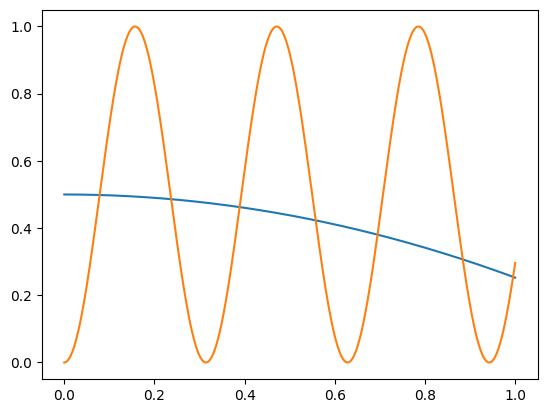

In [24]:
grn = GRN(best_individual, nin=1, nout=1)
# grn.setup()

t = np.linspace(0, 1, 500)

err, ypred = problem.eval(best_individual)
# grn.setup()
# grn.reset()
# grn.warmup(25)
# y=  []
# for ti in t:
#     grn.set_input([ti])
#     grn.step()
#     y.append(grn.get_output())
# print(grn.concentrations)

# plt.plot(t, y[:])
# plt.plot(t, np.sin(t)**2)
# plt.show()
plt.plot(t, ypred,)
# plt.plot(t, np.sin(t)**2)
plt.plot(t, problem.ytrain)
np.sum(abs(ypred-problem.ytrain))


print("error on test set", np.sum(abs(ypred-problem.ytrain)))
print("error on problem", err)
# np.linalg.norm(ypred - np.sin(t)**2)
# np.linalg.norm(y[:] - np.sin(t)**2)

In [17]:
len(best_individual), best_individual

print("best_individual", best_individual)
print(grn)

best_individual [0.9236092538015797, 0.895583221027693, 0.5817951367163828, 0.03933215119657352, 0.42606190835146296, 0.4155972821504099, 0.05889356042774807, 0.7088665136265556, 0.3974912537447697, 0.40718206026522785, 0.9595812148351709, 0.9748645095197572, 0.016147360738943295, 0.7829462955182397, 0.03759539398577616, 0.6050527859704987, 0.6791300176461315, 0.7632698806122282, 0.1187532278674448, 0.08969997976510313, 0.8590531568062966, 0.963309023184479, 0.3651259515248969, 0.14221211124855426, 0.3094418982253555, 0.896936129801076, 0.36375253679878516, 0.36192803967547227, 0.9514765212554603, 0.365094947632869, 0.3853813760859931, 0.6987207657174322, 0.5698288586808088, 0.26511194272456595, 0.610238132992318, 0.4322674827469203, 0.8879933718729491, 0.9197691262137142]
{'nin': 1, 'nout': 1, 'nreg': 10, 'beta': 0.9236092538015797, 'delta': 0.895583221027693, 'a': 0, 'f': 0, 'idsize': 1.0, 'identifiers': array([0.58179514, 0.03933215, 0.42606191, 0.41559728, 0.05889356,
       0.7088

[0.2 0.2 0.2 0.2 0.2]
5
concentration after warmup [0.         0.35816735 0.         0.         0.68689872]
{'nin': 1, 'nout': 1, 'nreg': 3, 'beta': 0.9116682507312829, 'delta': 1.8735, 'a': 0, 'f': 0, 'idsize': 1.0, 'identifiers': array([0.32002262, 0.53875186, 0.30636835, 0.13747037, 0.97652842]), 'enhancers': array([0.48307438, 0.48090997, 0.7544553 , 0.74180602, 0.37003506]), 'inhibiters': array([0.98429017, 0.76989283, 0.84782954, 0.90306246, 0.57703009])}
enh matrix  [[0.46625661 0.42277766 0.47209692 0.55068515 0.63014718]
 [0.46533749 0.42361272 0.47116629 0.5495996  0.63139183]
 [0.59713637 0.48918317 0.60461608 0.70526428 0.49203214]
 [0.59028978 0.48357434 0.59768373 0.69717793 0.49773907]
 [0.4205998  0.46867088 0.42586822 0.49676092 0.69855071]]
inh matrix shape  [[0.7363302  0.60321287 0.74555345 0.86966298 0.40470693]
 [0.60559983 0.49611657 0.61318555 0.71526028 0.48515583]
 [0.65019469 0.53264935 0.65833901 0.76793027 0.45188048]
 [0.68377296 0.56015719 0.69233788 0.80

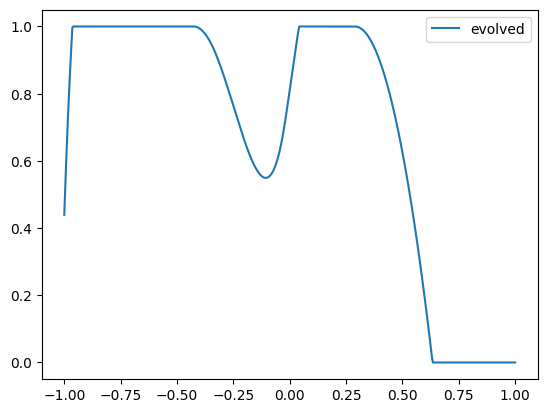

In [8]:
import numpy as np
from grn import GRN
from genome import *   
import matplotlib.pyplot as plt

# grn evolved with great from pygnr should looks like a square 


beta = 0.9116682507312829
delta = 1.8735
identifiers = [0.32002262, 0.53875186, 0.30636835, 0.13747037, 0.97652842]
enhancers = [0.48307438, 0.48090997, 0.7544553 , 0.74180602, 0.37003506]
inhibiters = [0.98429017, 0.76989283, 0.84782954, 0.90306246, 0.57703009]
a = 0
f = 0
genome = encode_genome(beta, delta, identifiers, enhancers, inhibiters)
gsquare = GRN(genome, nin=1, nout=1)

t = np.linspace(-1, 1, 500)

gsquare.setup()

print(gsquare.concentrations)
gsquare.warmup(25)
print(gsquare.size)
print("concentration after warmup", gsquare.concentrations)
ys = []
for ti in t:
    gsquare.set_input([ti])
    gsquare.step()
    ys.append(gsquare.get_output())


plt.plot(t, ys, label="evolved")
# plt.plot(t, ytrain, '.', label = "target")
plt.legend()

print(gsquare)
print("enh matrix ", gsquare.enh_afinity_matrix)
print("inh matrix shape ", gsquare.inh_affinity_matrix)

In [9]:
print(gsquare.genome)

gtest = GRN()
gtest.random(nin=1, nout=1, nreg=3)
gsquare_genome = gsquare.genome
gtest.from_genome(gsquare.genome)

gtest.warmup(25)
print(gtest.size)
print("concentration after warmup", gsquare.concentrations)
yss = []
for ti in t:
    gtest.set_input([ti])
    gtest.step()
    yss.append(gtest.get_output())


plt.plot(t, ys, '.' , label="evolved")
plt.plot(t, yss, '.', label="evolved")
# plt.plot(t, ytrain, '.', label = "target")
plt.legend()

[0.91166825 1.8735     0.32002262 0.53875186 0.30636835 0.13747037
 0.97652842 0.48307438 0.48090997 0.7544553  0.74180602 0.37003506
 0.98429017 0.76989283 0.84782954 0.90306246 0.57703009]


TypeError: GRN.__init__() missing 1 required positional argument: 'genome'

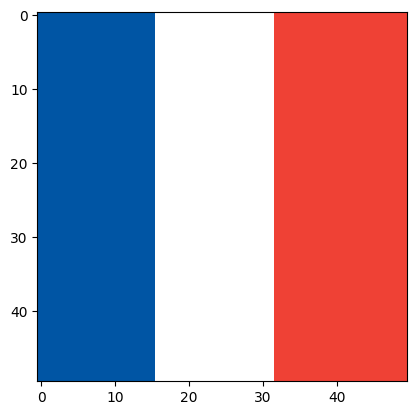

In [22]:
def french_flag(N):
    """
    Create a NxNx3 matrix representing the French flag.
    
    Blue | White | Red
    """
    flag = np.zeros((N, N, 3), dtype=np.uint8)  # RGB uint8 values 0-255

    # Width of each stripe
    stripe_width = N // 3

    # Blue stripe
    flag[:, :stripe_width, :] = [0, 85, 164]  # RGB for blue

    # White stripe
    flag[:, stripe_width:2*stripe_width, :] = [255, 255, 255]

    # Red stripe
    flag[:, 2*stripe_width:, :] = [239, 65, 53]  # RGB for red

    return flag/255.0

# Example usage
N = 50
flag = french_flag(N)
plt.imshow(flag)


def eval(individual):
    fit, _ = problem.eval(individual)
    return fit,